In [1]:
#!/usr/bin/env python

# data packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
# torch libraries
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

from sklearn.metrics import cohen_kappa_score

matplotlib.rc_file_defaults() 

# import dlc_practical_prologue as prologue
# train_input, train_target, test_input, test_target = \
#     prologue.load_data(one_hot_labels = True, normalize = True, flatten = False)

##########################################################
### data splitting
def split_data(x, y, ratio=0.90, seed=0):
    """split the dataset based on the split ratio."""
    # set seed
    np.random.seed(seed)
    # generate random indices
    dataset_size = x.shape[0]
    indices = np.random.permutation(dataset_size)
    threshold  = int(ratio * dataset_size)
    index_train = indices[:threshold]
    index_test = indices[threshold:]
    # create split
    x_training = x[index_train]
    x_test = x[index_test]
    y_training = y[index_train]
    y_test = y[index_test]
    return x_training, x_test, y_training, y_test

def balance_subset(samples,labels):    
    number_of_L = np.sum(labels, axis=0)
    scale = np.floor( min(number_of_L) )
    L_rows = np.where(labels[:,0]==1)
    D_rows = np.where(labels[:,1]==1)
    H_rows = np.where(labels[:,2]==1)
    
    minimum = min(len(L_rows[0]),len(D_rows[0]),len(H_rows[0]))
    
    sub_L = np.random.choice(L_rows[0] , minimum)
    sub_D = np.random.choice(D_rows[0] , minimum)
    sub_H = np.random.choice(H_rows[0] , minimum)
    
    rows=np.concatenate((sub_L, sub_D,sub_H), axis=None)    
    
    balanced_labels = labels[rows]
    balanced_samples = samples[rows]
    
    return balanced_samples, balanced_labels

##########################################################
#### data importing 
parquet_file = 'TCV_LHD_db4ML.parquet.part'
df = pd.read_parquet(parquet_file, engine ='auto')

##########################################################
#### removing spurious data
mask = df['LDH'] == 'Ip<Ip_MIN'
df_filter = df.drop(index = df[mask].index) #remove Ip<Ip_MIN values 

df_filter = df_filter.dropna() #remove Nan values
df_filter = df_filter.reset_index(drop=True) #reset indexing
df_filter.LDH = df_filter.LDH.cat.remove_categories('Ip<Ip_MIN') #remove Ip<Ip_MIN category

discard_data = len(df.index) - len(df_filter.index) # number of data point that do not contain useful information
print('number of useless data points: ', discard_data)
print('size of filtered data set: ', len(df_filter.index))
print('size of original data set: ', len(df.index))
print(len(df_filter.index) + discard_data - len(df.index))



AttributeError: Can only use .cat accessor with a 'category' dtype

In [45]:
##########################################################
# separation into experiments
# contruction of labels to numerical values

total_samples = 0
counter = 0 
window_size = 80
#datasize = datasize - datasize % batch size



num_pulses=int(max(df_filter['pulse'].values)) # tot number of different pulses == tot number of different experiments

for k in range(num_pulses):    
    mask_experiment = df_filter.pulse == k + 1
    df_experiment = df_filter[mask_experiment]
    df_experiment = df_experiment.reset_index(drop=True)    
    
    # labels
    maskl = df_experiment.LDH == 'L'
    maskd = df_experiment.LDH == 'D'
    maskh = df_experiment.LDH == 'H'
    labels = np.vstack((maskl, maskd, maskh)).T + 0.0
    
    features_exp = df_experiment.keys().to_numpy()
    #mask_features_exp = np.array([False, True, True, True, True, False, False ])
    mask_features_exp = np.array([False, True, True, True, True, False, False ])
    features_exp = features_exp[mask_features_exp]
    x_exp = np.array( df_experiment.loc[:, features_exp].values )    

    num_samples = int( x_exp.shape[0]/window_size )
    total_samples  += num_samples
    

number_correct_samples = total_samples
all_samples  = np.zeros(number_correct_samples * window_size * 4).reshape((-1, window_size, 4))
all_labels = np.zeros(number_correct_samples * 3).reshape((-1, 3))

for k in range(num_pulses):    
    print('running experiment ', k+1 )
    mask_experiment = df_filter.pulse == k + 1
    df_experiment = df_filter[mask_experiment]
    df_experiment = df_experiment.reset_index(drop=True)    
    
    # labels
    maskl = df_experiment.LDH == 'L'
    maskd = df_experiment.LDH == 'D'
    maskh = df_experiment.LDH == 'H'
    labels = np.vstack((maskl, maskd, maskh)).T + 0.0
    
    features_exp = df_experiment.keys().to_numpy()
    #mask_features_exp = np.array([False, True, True, True, True, False, False ])
    mask_features_exp = np.array([False, True, True, True, True, False, False ])
    features_exp = features_exp[mask_features_exp]
    x_exp = np.array( df_experiment.loc[:, features_exp].values )    

    ## PCA multiplication for each experiment
    #U, S, Vh = np.linalg.svd(x_exp, full_matrices=True)
    #x_exp = U.t() @ x_exp
    
    # this number varies from one experiment to another
    # total number of samples we can get from each experiment given
    # the time window
    num_samples = int( x_exp.shape[0]/window_size )
    step = 0
    
    
    for i in range(num_samples):
        all_samples[i + counter] = x_exp[ step : step + window_size, : ].reshape((-1, window_size, 4)) 
        all_labels[i + counter] = labels[ step : step + window_size, : ].mean(axis = 0).reshape((-1, 1, 3))                
        step += window_size
        
    counter +=num_samples
    total_samples  += num_samples

#all_samples, all_labels = balance_subset(all_samples,all_labels)    
    
# create of train and test set
validation_split = 0.50
shuffle_dataset = False
random_seed= 0
dataset_size = all_samples.shape[0]
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
train_indices, test_indices = indices[split:], indices[:split]

x_train = all_samples[train_indices]
y_train = all_labels[train_indices]

x_test = all_samples[test_indices]
y_test = all_labels[test_indices]

# transform into a tensor
x_train = torch.from_numpy(x_train).float().reshape(-1, 1, window_size, 4)[: 14000 ]
y_train = torch.from_numpy(y_train).float()[: 14000 ]
x_test = torch.from_numpy(x_test).float().reshape(-1, 1, window_size, 4)[: 14000 ]
y_test = torch.from_numpy(y_test).float()[: 14000 ]  

print('train set shape: ', x_train.shape)
print('test set shape: ', x_test.shape)

# counting the number of each class that we have in our set
label_class_1 = y_train == torch.tensor([1., 0., 0.]).view(-1,3)
label_class_2 = y_train == torch.tensor([0., 1., 0.]).view(-1,3) 
label_class_3 = y_train == torch.tensor([0., 0., 1.]).view(-1,3) 
label_transition = y_train < torch.tensor([1., 1., 1.]).view(-1,3)

label_class_1 = label_class_1 + 0.0
label_class_2 = label_class_2 + 0.0
label_class_3 = label_class_3 + 0.0
label_transition = label_transition + 0.0

total_class1 = label_class_1.prod(dim = 1).mean()
total_class2 = label_class_2.prod(dim = 1).mean()
total_class3 = label_class_3.prod(dim = 1).mean()
total_transition= label_transition.prod(dim = 1).mean()

print('class L total percent: ', total_class1*100)
print('class D total percent: ', total_class2*100)
print('class H total percent: ', total_class3*100)
print('transition total percent: ', total_transition*100)

### info regarding data shape for models to work 
'''
    train or test data must be torch.Size([1000, 1, 28, 28])
    size explanation tensor ( [ # N_samples , # channels_input, hight, width ] )                               
                       
    target or label tensor 
    torch.Size([N_samples, # labels/classes])
                                   
'''



running experiment  1
running experiment  2
running experiment  3
running experiment  4
running experiment  5
running experiment  6
running experiment  7
running experiment  8
running experiment  9
running experiment  10
running experiment  11
running experiment  12
running experiment  13
running experiment  14
running experiment  15
running experiment  16
running experiment  17
running experiment  18
running experiment  19
running experiment  20
running experiment  21
running experiment  22
running experiment  23
running experiment  24
running experiment  25
running experiment  26
running experiment  27
running experiment  28
running experiment  29
running experiment  30
running experiment  31
running experiment  32
running experiment  33
running experiment  34
running experiment  35
running experiment  36
running experiment  37
running experiment  38
running experiment  39
running experiment  40
running experiment  41
running experiment  42
running experiment  43
running experiment  

'\n    train or test data must be torch.Size([1000, 1, 28, 28])\n    size explanation tensor ( [ # N_samples , # channels_input, hight, width ] )                               \n                       \n    target or label tensor \n    torch.Size([N_samples, # labels/classes])\n                                   \n'

In [46]:
x_train.shape

torch.Size([14000, 1, 80, 4])

training started
epoch: 0, loss: 15.388013124465942
epoch: 1, loss: 15.383387684822083
epoch: 2, loss: 15.380539178848267
epoch: 3, loss: 15.377928376197815
epoch: 4, loss: 15.37263023853302
epoch: 5, loss: 15.370941400527954
epoch: 6, loss: 15.366585373878479
epoch: 7, loss: 15.363551020622253
epoch: 8, loss: 15.360033512115479
epoch: 9, loss: 15.35598611831665
epoch: 10, loss: 15.352139353752136
epoch: 11, loss: 15.348288416862488
epoch: 12, loss: 15.344662070274353
epoch: 13, loss: 15.343003273010254
epoch: 14, loss: 15.339405417442322
epoch: 15, loss: 15.335854887962341
epoch: 16, loss: 15.331225991249084
epoch: 17, loss: 15.327721357345581
epoch: 18, loss: 15.32513678073883
epoch: 19, loss: 15.321354031562805
epoch: 20, loss: 15.31722092628479
epoch: 21, loss: 15.313179969787598
epoch: 22, loss: 15.309136986732483
epoch: 23, loss: 15.306248664855957
epoch: 24, loss: 15.302897095680237
epoch: 25, loss: 15.298012256622314
epoch: 26, loss: 15.292998790740967
epoch: 27, loss: 15.29070

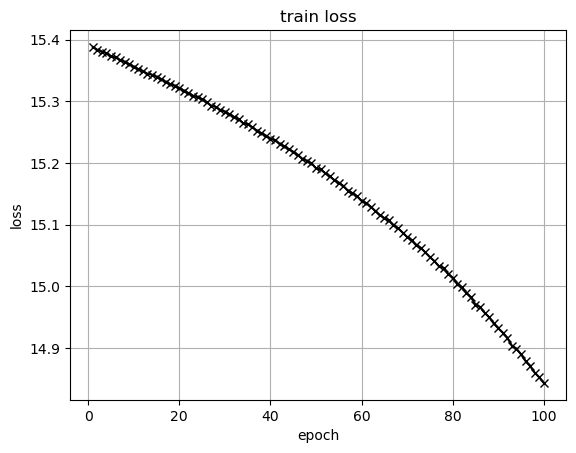

In [48]:
#%%
######################################################################
class Net(nn.Module):
    def __init__(self, nb_hidden):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=2, padding =1, padding_mode = 'replicate' ),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16),
            nn.ReLU()
            )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=2, padding =1, padding_mode = 'replicate' ),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16),
            nn.ReLU()
            )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=2, padding =1, padding_mode = 'replicate' ),            
            nn.BatchNorm2d(32),
            nn.ReLU()
            )
                
        self.fc1 = nn.Linear( 32 * 21 * 2 , 2 * nb_hidden)
        self.fc2 = nn.Linear( 2 * nb_hidden , nb_hidden )
        self.fc3 = nn.Linear( nb_hidden , nb_hidden )
        self.fc4 = nn.Linear( nb_hidden, 3)
        
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        x = self.conv1(x) # ouput shape torch.Size([100, 16, 10, 2])
        x = self.conv2(x) # ouput shape torch.Size([100, 16, 5, 1])
        x = self.conv3(x) # ouput shape torch.Size([100, 32, 3, 1])        
        x = x.view(-1, 32 * 21 * 2  )
        x = F.relu(self.fc1(x))
        x = self.dropout( x )
        x = F.relu(self.fc2(x))
        x = self.dropout( x )
        x = F.relu(self.fc3(x))
        x = self.dropout( x )
        x = self.fc4(x)         
        #return x
        return F.softmax(x, dim = 1)
    
######################################################################

def train_model(model, train_input, train_target, mini_batch_size, acc_loss_vector, nb_epochs = 50):
    lr = 1e-5
    criterion = nn.CrossEntropyLoss()        
    #optimizer = optim.SGD(model.parameters(), lr = lr,  momentum=0.9)    
    #optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.9), lr=lr)
    optimizer = optim.AdamW(model.parameters(),lr=lr, betas=(0.9, 0.99), weight_decay=0.1)
    
    #acc_loss_vector = torch.zeros(nb_epochs) 
    for e in range(nb_epochs):
        acc_loss = 0          
        for b in range(0, train_input.size(0), mini_batch_size):            
            output = model(train_input.narrow(0, b, mini_batch_size))            
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size).squeeze())
            acc_loss = acc_loss + loss.item()            
            model.zero_grad()
            loss.backward()
            optimizer.step()
        acc_loss_vector[e] = acc_loss
        print('epoch: ' +  str(e) + ', loss: ' + str(acc_loss) )
    
def compute_nb_errors(model, data_input, data_target, mini_batch_size):    
    nb_data_errors = 0    
    with torch.no_grad():
        for b in range(0, data_input.size(0), mini_batch_size):
            output = model(data_input.narrow(0, b, mini_batch_size))    
            _, predicted = torch.max(output, 1)    
            for k in range(mini_batch_size):
                if data_target[b + k].view(-1, 3).max(1)[1]  != predicted[k] :
                    nb_data_errors = nb_data_errors + 1
    return nb_data_errors

#######################################################################
mini_batch_size = 1000
nb_hidden = 100

# to train in GPU if available 
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cuda')
# print('working device ', device)
# Net2.to(device)
# x_test, y_test = x_test.to(device), y_test.to(device)

# # train with H states only
# label_class_3_train = y_train == torch.tensor([0., 0., 1.]).view(-1,3) 
# label_class_3_train = label_class_3_train + 0.0
# mask_H = label_class_3_train.prod(dim = 1) > 0 

# # data to feed model
# data_train_H = x_train[mask_H] [: 20000]
# labels_train_H = y_train[mask_H] [: 20000]

# model training
nb_epochs = 100
acc_loss_vector = torch.zeros(nb_epochs) 
model = Net(nb_hidden)
model.train()
print('training started')
train_model(model, x_train, y_train, mini_batch_size, acc_loss_vector, nb_epochs)
print('training finished')

# data to test model accuracy
label_class_2_test = y_test == torch.tensor([0., 1., 0.]).view(-1,3) 
label_class_2_test = label_class_2_test + 0.0
mask_H_test = label_class_2_test.prod(dim = 1) > 0 
x_test_H = x_test[mask_H_test][: 3000]
y_test_H = y_test[mask_H_test][: 3000]

# model(data_test_H)
#%%
#######################################################################
nb_train_errors = compute_nb_errors(model, x_train, y_train, mini_batch_size) / x_train.size(0) * 100
print('train error: ', str(nb_train_errors) + '%')

nb_test_errors = compute_nb_errors(model, x_test, y_test, mini_batch_size) / x_test.size(0) * 100
print('test error: ' +str(nb_test_errors) + '%')

# cohen score
#cohen_result = cohen_kappa_score(torch.max(model(x_test), 1), y_test.max(1)[1] )           

plt.plot( torch.arange(1, nb_epochs+1), acc_loss_vector, marker='x', c = 'k');
plt.title('train loss');
plt.xlabel('epoch');
plt.ylabel('loss');
plt.grid(True);
plt.show();

In [ ]:
epochs = 50
WINDOW = 5
train error: 35.59180327868852%
test error: 40.617213114754094%

WINDOW = 10
train error:  35.58032786885246%
test error: 40.571311475409836%
    
WINDOW = 20
train error:  35.35806451612903%
test error: 40.67258064516129%

WINDOW = 40
Train 35.41612903225806%
Test 40.71612903225807%

WINDOW = 80
train error:  36.32142857142857%
test error: 42.199999999999996%
    
WINDOW = 160    
train error:  36.57142857142857%
test error: 41.98571428571429%
    

Smalest windows = more computational power
Smaller windows -> faster loss optimisation (less epochs needed)

In [122]:
Test_error = [40.617213114754094 , 40.571311475409836 ,40.67258064516129 ,40.71612903225807 ,42.199999999999996 ,41.98571428571429]
Window_size = [5, 10 ,20, 40, 80, 160]
epochs1= [30, 50, 50, 50, 100, 150]

<function matplotlib.pyplot.show(close=None, block=None)>

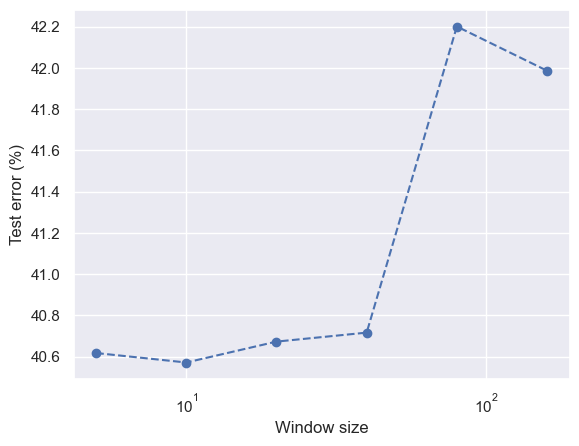

In [113]:
import seaborn as sns

fig1, ax1 = plt.subplots()
ax1.plot(Window_size, Test_error,'bo--')
#ax1.xscale('log')
ax1.set_xscale('log')

plt.xlabel(r"Window size")
plt.ylabel(r"Test error (%)")
#ax.set_xticks([5, 10, 20, 40, 80, 160])
ax.get_xaxis().get_major_formatter().labelOnlyBase = False

plt.show

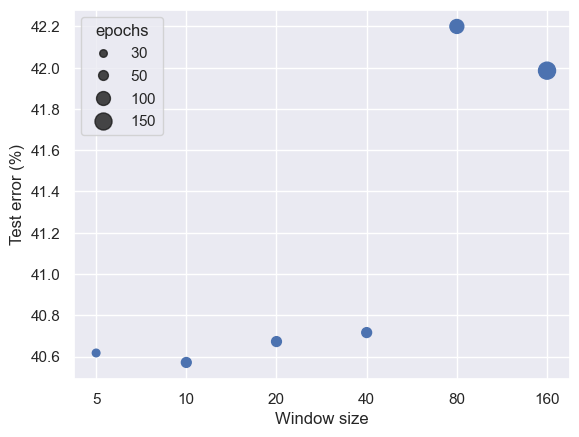

In [152]:
import matplotlib
from matplotlib import pyplot as plt
fig1, ax1 = plt.subplots()
scatter = ax1.scatter(Window_size, Test_error, epochs1)
ax1.set_xscale('log')
ax1.set_xticks(Window_size)
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xlabel(r"Window size")
plt.ylabel(r"Test error (%)")
plt.legend(('No mask','sad'), loc='upper left')

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.8)
legend2 = ax1.legend(handles, labels, loc="upper left", title="epochs")